In [1]:
import numpy as np
import scipy.optimize
from scipy import constants
from scipy.integrate import quad
from scipy.integrate import quadrature
import matplotlib.pyplot as plt

In [28]:
m_T = 2.1188477e-22 #g

m_S = 4.6637066e-23 #g
p_S = 4.3 #g/cm3
N_S = p_S/m_S #1/cm3


n = 1
Z = 14
V_0 = 13.6 * Z**2 * n / (n+1) #eV
a = -1 / .3 * np.log(12*Z*n**2/V_0)

c = 2.99792458e10 #cm/s
beta = 1.0e-4
v_0 = beta*c

E_inc = 1/2*m_S*(beta*c)**2 * 6.242e+11 #eV

In [52]:
#Potentials

def U_1(r):
    return V_0 * np.exp(-a * r * 1e+8)

def U_2(r):
    return (1e-8)**4 * 0.0972 * Z * n**2 / r**4

In [55]:
# functions for finding r_min

def radicand_1(r, b, m, v):
    #return 2*m_T*(1/2*m_T*v_0**2-U_1(r)) - (m_T*b*v_0)**2/r**2
    return 1 - (b / r)**2 - 2*U_1(r) / (m * v**2 * 6.242e+11)

def radicand_2(r, b, m, v):
    #return 2*m_T*(1/2*m_T*v_0**2-U_1(r)) - (m_T*b*v_0)**2/r**2
    return 1 - (b / r)**2 - 2*U_2(r) / (m * v**2 * 6.242e+11)

#def min_r(b, m, v):
#    alpha = (1e-8)**4 * 0.097 * Z * n**2
#    return np.sqrt(b**2/2 + 1/2*np.sqrt(b**4 + 4 * 2 * alpha / m / v**2))

#b_0 = 1e-9

In [56]:
v_1 = 1e-3*c

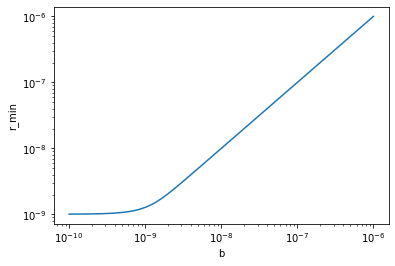

In [57]:
mins = []
bspace = np.logspace(-10, -6, 100)
for b in bspace:
    r_min = scipy.optimize.root_scalar(radicand_2, args=(b, m_S, v_1) , bracket=[1e-12, 1e+5], xtol=1e-20) #1e-7)  #, f_tol=1e-35)
    mins.append(r_min.root)

plt.plot(bspace, mins)
plt.xlabel("b")
plt.ylabel("r_min")

plt.gca().set_xscale("log")
plt.gca().set_yscale("log")

In [58]:
scipy.optimize.root_scalar(radicand_2, args=(1e-9, m_S, v_1) , bracket=[1e-12, 1e+5], xtol=1e-20)

      converged: True
           flag: 'converged'
 function_calls: 57
     iterations: 56
           root: 1.2790157808313453e-09

In [59]:
# Integrands corresponding to each potential

def integrand_1(r, b, m, v):
    
    return (b / (r)**2) / np.sqrt(radicand_1(r, b, m, v))

def integrand_2(r, b, m, v):
    
    return (b / (r)**2) / np.sqrt(radicand_2(r, b, m, v))

In [60]:
import math

In [1663]:
# Function which performs numeric integration on above integrands to find theta(b)

from math import floor, log10

def theta_b (b, m ,beta):
    
    v = beta*c
    
    res = scipy.optimize.root_scalar(radicand_2, args=(b, m, v) , bracket=[1e-20, 1e+5], xtol=1e-25) #1e-7)  #, f_tol=1e-35)
    r_min2 = res.root
    #r_min2 = min_r(b, m, v)
        
    #print(r_min1)
    #print(r_min2)
    #print(r_min2 < .3e-8)

    if r_min2 > .3e-8:
        I_1 = 0
        
        #bound adjustment for integratin fix
        if r_min2 < 1e-7:
            bound = 1e-7
        if r_min2 < 1e-4:
            bound = 1e-4
        elif r_min2 < 1.0:
            bound = 1.0
        else:
            bound = 1.0
        
        I_2 = quad(integrand_2, r_min2, bound, args=(b, m, v), epsrel=0, epsabs=1e-16, limit=1000)[0] +\
                quad(integrand_2, bound, np.inf, args=(b, m, v), epsrel=0, epsabs=1e-16, limit=1000)[0]
    else:
        
        res = scipy.optimize.root_scalar(radicand_1, args=(b, m, v) , bracket=[1e-25, 1e+5], xtol=1e-25) #1e-7)  #, f_tol=1e-35)
        r_min1 = res.root
        
        if r_min2 > r_min1:
            r_min1 = r_min2
        
        '''
        boundaries = [1e-18, 1e-15, 1e-12, .3e-8]
        I_1 = 0
        
        for i in range(len(boundaries)):
            
            if r_min1 >= boundaries[i]:
                continue
            else:
                new_boundaries = [r_min1] + boundaries[i:]
                
                for j in range(len(new_boundaries) - 1):
                    res = quad(integrand_1, new_boundaries[j], new_boundaries[j+1], args=(b, m, v), epsrel=0, epsabs=1e-16, limit=1000)
                    print(res)
                    
                    if res[0] < 0:
                        print("error")
                        return 0
                    else:
                        I_1 += res[0]
                
                break
        '''
        
        if r_min1 > 1e-10:
            I_1 = quad(integrand_1, r_min1, .3e-8, args=(b, m, v), epsrel=0, epsabs=1e-16)[0]
            
        else:
            I_1 = quad(integrand_1, r_min1, 1e-10, args=(b, m, v), epsrel=0, epsabs=1e-16)[0] +\
                quad(integrand_1, 1e-10, .3e-8, args=(b, m, v), epsrel=0, epsabs=1e-16)[0]
        
        #r_min2 = scipy.optimize.root_scalar(radicand_2, args=(b, m, v) , bracket=[1e-20, 1e+5], xtol=1e-25).root
        #I_1 = quad(integrand_2, r_min2, .3e-8, args=(b, m, v), epsrel=0, epsabs=1e-16)[0]
        
        I_2 = quad(integrand_2, .3e-8, 1e-4, args=(b, m, v), epsrel=0, epsabs=1e-16)[0] +\
                quad(integrand_2, 1e-4, np.inf, args=(b, m, v), epsrel=0, epsabs=1e-16, limit=1000)[0]
        
        
        if I_1 < 0 or I_2 < 0 or math.isnan(I_1) or math.isnan(I_2):
            print('error')
            print("I_1: " + str(I_1))
            print("I_2: " + str(I_2))
            print(r_min1)
            return None
    
    #I_2 = quad(integrand_2, .3e-8, np.inf, args=(b, m, v), epsabs=0)[0]
    
    #print("I_1: " + str(I_1))
    #print("I_2: " + str(I_2))
    #print("sum: " + str(I_1 + I_2))
    #print()
    
    phi = I_1 + I_2
    
    if(math.isnan(phi)):
        print(b)
    
    theta =  np.pi - 2 * phi
    
    if theta < 1e-10:
        return 0
    else:
        return theta
    
    return theta

/Users/julianyocum/opt/anaconda3/envs/UROP/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/Users/julianyocum/opt/anaconda3/envs/UROP/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


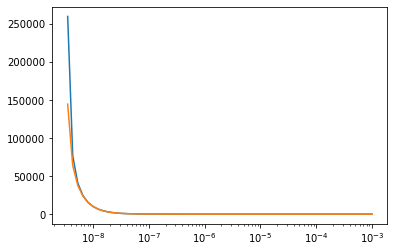

In [62]:
rspace = np.logspace(-12, -3, 100)
plt.plot(rspace, integrand_1(rspace, 1e-12, m_S, v_0))
plt.plot(rspace, integrand_2(rspace, 1e-12, m_S, v_0))


plt.gca().set_xscale("log")
#plt.gca().set_yscale("log")

/Users/julianyocum/opt/anaconda3/envs/UROP/lib/python3.7/site-packages/ipykernel_launcher.py:28: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
/Users/julianyocum/opt/anaconda3/envs/UROP/lib/python3.7/site-packages/ipykernel_launcher.py:28: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/Users/julianyocum/opt/anaconda3/envs/UROP/lib/python3.7/site-packages/ipykernel_launcher.py:29: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


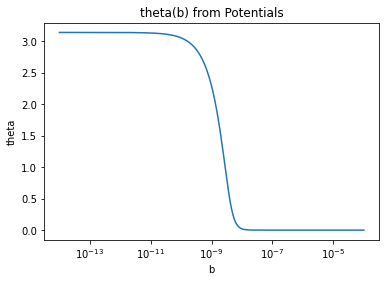

In [1603]:
v_2 = c*1e-3
bspace = np.logspace(-14, -4, 1000)
thetas = [theta_b(b, m_S, v_2) for b in bspace]
    
plt.plot(bspace, thetas)

plt.title("theta(b) from Potentials")
plt.xlabel("b")
plt.ylabel("theta")

#plt.axvline(.3e-8)

plt.gca().set_xscale("log")
#plt.gca().set_yscale("log")

In [13]:
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline

In [1664]:
#build spline for b(theta):

def make_b(beta, m):
    l_bound = 1e-22
    u_bound = 1e-3
        
    y = np.logspace(np.log10(l_bound), np.log10(u_bound), 1000)
    x = np.array([theta_b(b, m, beta) for b in y])
    x = x[::-1]
    y = y[::-1]
    
    x[0] = 0
    #x = x * (x > theta_lim)
    y[0] = u_bound
    
    x[-1] = np.pi
    y[-1] = l_bound
    
    while(x[1] == 0):
        x = np.delete(x, 0)
        y = np.delete(y, 0)
            
    y = [yi for _,yi in sorted(zip(x,y))]
    x = np.array(sorted(x))
    
    #print(x)
    #print(y)
    
    dx = np.diff(x)
    if np.any(dx <= 0):
        print("fuck")
        print(x)
        
    #max_index = np.where(x > theta_min)[0][0]
        
    b_min = y[-1]
    b_max = y[0] #y[max_index]
    
    #del y[:1]
    
    #b = interp1d(x, y, kind='cubic')
    return (CubicSpline(x, y), b_min, b_max)

In [1565]:
res, err = dEdx(1e-5, theta_min=1e-2, integration_diagnostics=False)
res * 1e-9

/Users/julianyocum/opt/anaconda3/envs/UROP/lib/python3.7/site-packages/ipykernel_launcher.py:29: IntegrationWarning: The integral is probably divergent, or slowly convergent.
/Users/julianyocum/opt/anaconda3/envs/UROP/lib/python3.7/site-packages/ipykernel_launcher.py:28: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
/Users/julianyocum/opt/anaconda3/envs/UROP/lib/python3.7/site-packages/ipykernel_launcher.py:28: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/Users/julianyocum/opt/anaconda3/envs/UROP/lib/python3.7/site-packages/ipykernel_launcher.py:29: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested toler

1.6126029523523704

/Users/julianyocum/opt/anaconda3/envs/UROP/lib/python3.7/site-packages/ipykernel_launcher.py:28: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
/Users/julianyocum/opt/anaconda3/envs/UROP/lib/python3.7/site-packages/ipykernel_launcher.py:28: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/Users/julianyocum/opt/anaconda3/envs/UROP/lib/python3.7/site-packages/ipykernel_launcher.py:29: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


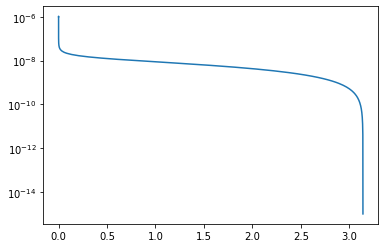

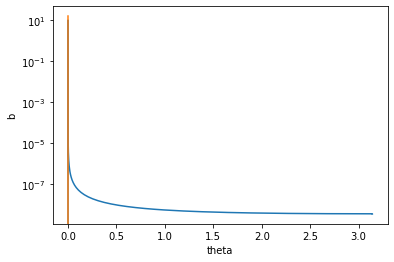

In [595]:
ynew = np.logspace(-15, -4, 400)
xnew = [theta_b(b, m_S, v_0) for b in ynew]


plt.plot(xnew, b(xnew))
plt.gca().set_yscale("log")
#plt.gca().set_xscale("log")

#plt.xlim(3, np.pi)


plt.figure()

#plt.plot(xnew, ynew, 'o')
plt.plot(xnew, -b.derivative()(xnew))
plt.plot(xnew, b.derivative()(xnew))


#plt.plot(np.linspace(0, np.pi, 1000), -b.derivative()(np.linspace(0, np.pi,1000)))

plt.xlabel("theta")
plt.ylabel("b")

plt.gca().set_yscale("log")
#plt.gca().set_xscale("log")

#plt.xlim(3, np.pi)


Text(0, 0.5, 'b')

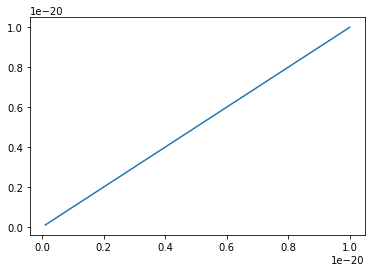

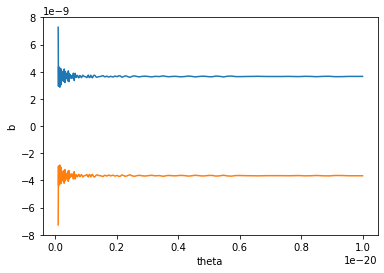

In [311]:
ynew = np.logspace(-22, -20, 200)
xnew = [theta_b(b, m_S, v_0) for b in ynew]


plt.plot(ynew, b(xnew))
#plt.gca().set_yscale("log")
#plt.gca().set_xscale("log")


plt.figure()

#plt.plot(xnew, ynew, 'o')
plt.plot(ynew, -b.derivative()(xnew))
plt.plot(ynew, b.derivative()(xnew))


#plt.plot(np.linspace(0, np.pi, 1000), -b.derivative()(np.linspace(0, np.pi,1000)))

plt.xlabel("theta")
plt.ylabel("b")

#plt.gca().set_yscale("log")
#plt.gca().set_xscale("log")




In [321]:
#Equation 11

def theta(K, E): 
    return 2 * np.arcsin(np.sqrt(K/(4*E)))


def K(theta, E):
    return 4*E* (np.sin(theta/2))**2


#Equation 10

def sigma(K, E, b):
    return - b.derivative()(theta(K, E)) * b(theta(K, E)) / np.sin(theta(K, E))

/Users/julianyocum/opt/anaconda3/envs/UROP/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in arcsin
  after removing the cwd from sys.path.
/Users/julianyocum/opt/anaconda3/envs/UROP/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in arcsin
  after removing the cwd from sys.path.


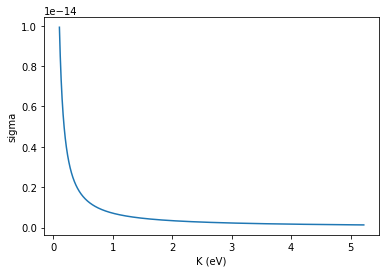

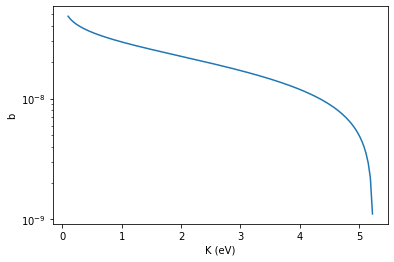

In [613]:
beta = 1e-5
E_inc = 1/2*m_S*(beta*c)**2 * 6.242e+11 # ergs -> eV
b, b_min, b_max = make_b(beta*c)

Ks = np.logspace(-1, 2, 1000)

plt.ylabel("sigma")
plt.xlabel("K (eV)")

plt.plot(Ks, sigma(Ks, E_inc, b))

#plt.xlim(0,2)

#plt.gca().set_xscale("log")
#plt.gca().set_yscale("log")



plt.figure()

plt.ylabel("b")
plt.xlabel("K (eV)")

plt.plot(Ks, b(theta(Ks, E_inc)))

#plt.gca().set_xscale("log")
plt.gca().set_yscale("log")




In [1649]:
def dEdx(beta, m, angle_diagnostics=False, integration_diagnostics=False):
    
    E_inc = 1/2* m *(beta*c)**2 * 6.242e+11 # ergs -> eV
    b, b_min, b_max = make_b(beta*c)
    
    if angle_diagnostics:
        b_test = np.logspace(-20, -6, 100)
        theta_test = [theta_b(b, m_S, v_0) for b in b_test]
        plt.plot(theta_test,b(theta_test))
        #plt.plot(np.logspace(-5,np.log10(np.pi),100),-b(np.logspace(-5,np.log10(np.pi),100)))
        plt.gca().set_yscale("log")
        plt.show()
        
    b_max = 5 / 2 * 1e-8
        
    K_min = K(theta_b(b_max, m, beta*c), E_inc)
    K_max = K(theta_b(b_min, m, beta*c), E_inc)
    
    boundaries = [K_min, 1e-11, 1e-8, 1e-5, 1e-2, 1, K_max]
    
    summ, err = integrate(sigma, boundaries, l_bound=K_min, args=(E_inc, b), verbose=integration_diagnostics)
        
    return (N_S*summ, N_S*err)

/Users/julianyocum/opt/anaconda3/envs/UROP/lib/python3.7/site-packages/ipykernel_launcher.py:29: IntegrationWarning: The integral is probably divergent, or slowly convergent.
/Users/julianyocum/opt/anaconda3/envs/UROP/lib/python3.7/site-packages/ipykernel_launcher.py:28: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
/Users/julianyocum/opt/anaconda3/envs/UROP/lib/python3.7/site-packages/ipykernel_launcher.py:28: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/Users/julianyocum/opt/anaconda3/envs/UROP/lib/python3.7/site-packages/ipykernel_launcher.py:29: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested toler

Text(0.5, 0, 'beta')

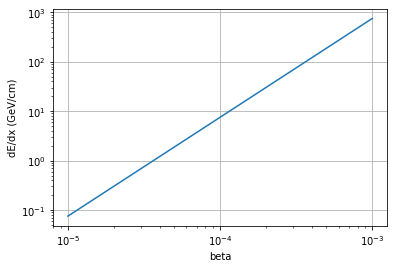

In [1650]:


betas = np.logspace(-5, -3, 5)
Es1 = np.array([dEdx(beta)[0] for beta in betas])
#Es2 = np.array([dEdx(beta, 2)[0] for beta in betas])

plt.plot(betas, Es1 * 1e-9)
#plt.plot(betas, Es2 * 1e-9)

plt.gca().set_xscale("log")
plt.gca().set_yscale("log")

plt.grid()

plt.ylabel("dE/dx (GeV/cm)")
plt.xlabel("beta")

In [213]:
p_Fe = 11.5 #g * cm^-3
m_Fe = 9.2732796e-23 #g
mu = 2.14 #Bohr magnetons

N_Fe = p_Fe / m_Fe # cm^-3

n = 1
g_D = 3.29e-8 #esu
g = n * g_D

c = 2.9979e+10 #cm / s
e = 4.8032e-10 #esu
hbar = 1.0546e-27 #erg*s
m_e = 9.1094e-28 #g

In [214]:
def para_dEdx():
    return .6  * mu * 4* np.pi * hbar * g * e * N_Fe / (c * m_e) * (6.242e+11 * 1e-9)

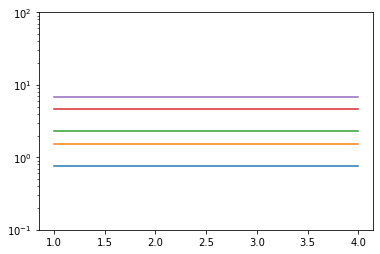

In [240]:

for n in [1,2,3,6,9]:
    g = n * g_D

    plt.plot(np.arange(1,5), [para_dEdx()]*4)
    plt.gca().set_yscale("log")
    plt.ylim(0.1, 100)

In [987]:
def integrate(f, bounds, l_bound=None, args=None, verbose=False):
    
    used_l_bound = False
    summ = 0
    tot_err = 0
    for i in range(len(bounds) - 1 + bool(l_bound)):
        
        if l_bound and not used_l_bound:
            
            if l_bound >= bounds[i]:
                continue
            else:
                bounds.insert(i, l_bound)
                #res, err = quad(f, l_bound, bounds[i], args=args, epsrel=0, epsabs=1e-16, limit=1000)
                used_l_bound = True
                
            
        res, err = quad(f, bounds[i], bounds[i+1], args=args, epsrel=0, epsabs=1e-16, limit=1000)
        
        if verbose:
            print("Integrating: [{},{}]".format(bounds[i], bounds[i+1]))
            print(res, err)
            
        if res <= 0:
            print("Integration error")
            return (-1, -1)
        else:
            summ += res
            tot_err += err
    
    return summ, tot_err

In [1149]:
np.exp(-a*1) / np.sqrt((1)**2 - (1)**2)

/Users/julianyocum/opt/anaconda3/envs/UROP/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  """Entry point for launching an IPython kernel.


inf

In [1182]:
far_integrand(1e-10, 1e-11)

1005037815259.2118

In [1180]:
b = 1e-10
integrate(far_integrand, [1e-12, 1e-11, 1e-10, .3e-8], l_bound=b, args=b, verbose=True)

Integrating: [1e-10,3e-09]
58.90486143139841 1.1051548565177427e-10


/Users/julianyocum/opt/anaconda3/envs/UROP/lib/python3.7/site-packages/ipykernel_launcher.py:18: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.


(58.90486143139841, 1.1051548565177427e-10)

In [1306]:
def close_integrand(r, b):
    b *= 1e+8
    r *= 1e+8
    return np.exp(-a*r) / np.sqrt(r**2 - b**2)

def far_integrand(r, b):
    b *= 1e+8
    r *= 1e+8
    return 1 / (r**5 * np.sqrt(r**2 - b**2))

def impulse_theta_b(b, beta):
    
    v_0 = beta*c
    E_inc = 1/2*m_S*v_0**2 * 6.242e+11 # ergs -> eV
    
    if b < .3e-8:
        
        close_integral = integrate(far_integrand, [1e-12, 1e-11, 1e-10, .3e-8], l_bound=b, args=b)[0]
        far_integral = integrate(far_integrand, bounds=[.3e-8, 1e-7, 1e-5, 2e-5, 1e-4, 1e-2, 1, np.inf], args=b)[0]
        
        far_integral += close_integral
        close_integral = 0
    
    else:
        close_integral = (0, 0)[0]
        far_integral = integrate(far_integrand, bounds=[1e-7, 1e-5, 2e-5, 1e-4, 1e-2, 1, np.inf], l_bound=b, args=b)[0]

    #far_integral = 0
    
    b *= 1e+8
    #print(a * b * V_0 / np.sqrt(2*E_inc / m_S) * 2 * close_integral)
    #print(4*.097*Z*n**2 * b / np.sqrt(2*E_inc / m_S) * 2 * far_integral)

    I = a * b * V_0 / np.sqrt(2*E_inc / m_S) * 2 * close_integral + \
        4*.097*Z*n**2 * b / np.sqrt(2*E_inc / m_S) * 2 * far_integral
    
    
    #print(quad(close_integrand, b, np.inf, args=b))
    #I = a * b * V_0 / np.sqrt(2*E_inc / m_S) * 2 * quad(close_integrand, b, np.inf, args=b)[0]
    
    #print("I: " + str(I))
    p = m_S * v_0
    
    
    #print(I)
    #print(far_integral)
    
    return np.arctan(I / p)

In [1301]:
quad(close_integrand, 1e-8, 1e-6, args=1e-9)

(1.3118208728758695e-12, 2.565524452787518e-12)

In [1302]:
far_integrand(1e-8, 1e-9)

1.005037815259212

In [1303]:
impulse_theta(.2e-8, 1e-5)

1.569774161108472

/Users/julianyocum/opt/anaconda3/envs/UROP/lib/python3.7/site-packages/ipykernel_launcher.py:18: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
/Users/julianyocum/opt/anaconda3/envs/UROP/lib/python3.7/site-packages/ipykernel_launcher.py:18: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/Users/julianyocum/opt/anaconda3/envs/UROP/lib/python3.7/site-packages/ipykernel_launcher.py:18: IntegrationWarning: The integral is probably divergent, or slowly convergent.


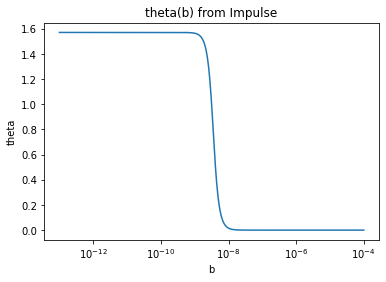

In [1604]:
bspace = np.logspace(-13, -4, 1000)
thetas = [impulse_theta(b, 1e-4) for b in bspace]
    
plt.plot(bspace, thetas)

plt.title("theta(b) from Impulse")
plt.xlabel("b")
plt.ylabel("theta")

#plt.axvline(.3e-8)

plt.gca().set_xscale("log")
#plt.gca().set_yscale("log")

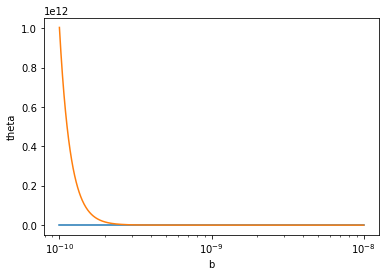

In [1289]:
bspace = np.logspace(-10, -8, 1000)
ints1 = [close_integrand(r, 1e-11) for r in bspace]
ints2 = [far_integrand(r, 1e-11) for r in bspace]
    
plt.plot(bspace, ints1)
plt.plot(bspace, ints2)

plt.xlabel("b")
plt.ylabel("theta")

#plt.axvline(.3e-8)

plt.gca().set_xscale("log")
#plt.gca().set_yscale("log")

In [1578]:
#build spline for b(theta):

def impulse_make_b(beta, theta_min=1e-6):
    l_bound = 1e-11
    u_bound = 1e-5
        
    y = np.logspace(np.log10(l_bound), np.log10(u_bound), 400, np.float64)
    x = np.array([impulse_theta_b(b, beta) for b in y], np.float64)
    x = x[::-1]
    y = y[::-1]
    
    x[0] = 0
    #x = x * (x > theta_lim)
    y[0] = u_bound
    
    x[-1] = np.pi/2
    y[-1] = l_bound
    
    while(x[1] == 0):
        x = np.delete(x, 0)
        y = np.delete(y, 0)
        
    #while(x[-2] == x[-3]):
    #    x = np.delete(x, -3)
    #    y = np.delete(y, -3)
            
    y = [yi for _,yi in sorted(zip(x,y))]
    x = np.array(sorted(x))
    
    #print(x)
    #print(y)
    
    dx = np.diff(x)
    if np.any(dx <= 0):
        print("fuck")
        print(dx)
        
    #print(x[-3])
    #print(x[-2])
    
    max_index = np.where(x > theta_min)[0][0]
        
    b_min = y[-1]
    b_max = y[max_index]
    
    #del y[:1]
    
    #b = interp1d(x, y, kind='cubic')
    return (CubicSpline(x, y), b_min, b_max)

In [1579]:
impulse_dEdx(1e-5, theta_min=1e-6)[0] * 1e-9

1e-05


/Users/julianyocum/opt/anaconda3/envs/UROP/lib/python3.7/site-packages/ipykernel_launcher.py:18: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
/Users/julianyocum/opt/anaconda3/envs/UROP/lib/python3.7/site-packages/ipykernel_launcher.py:18: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/Users/julianyocum/opt/anaconda3/envs/UROP/lib/python3.7/site-packages/ipykernel_launcher.py:18: IntegrationWarning: The integral is probably divergent, or slowly convergent.


14.591975143255604

In [1661]:
def impulse_dEdx(beta, theta_min=1e-15, anglediagnostics=False, integration_diagnostics=False):
    print(beta)
    
    E_inc = 1/2*m_S*(beta*c)**2 * 6.242e+11 # ergs -> eV
    b, b_min, b_max = impulse_make_b(beta, theta_min)
    if anglediagnostics:
        b_test = np.logspace(-16, -6, 100)
        theta_test = [impulse_theta_b(b, beta) for b in b_test]
        plt.plot(theta_test,b(theta_test))
        #plt.plot(np.logspace(-5,np.log10(np.pi),100),-b(np.logspace(-5,np.log10(np.pi),100)))
        plt.gca().set_yscale("log")
        plt.show()
        
    b_max = .235 / 2 * 1e-7
        
    K_min = K(impulse_theta_b(b_max, beta), E_inc)
    K_max = K(impulse_theta_b(b_min, beta), E_inc)
    
    print("K_min: " + str(K_min))
    print()
    #K_max = 2 * m_S * beta**2 * 6.242e+11
    
    boundaries = [1e-15, 1e-11, 1e-8, 1e-5, 1e-2, 1, K_max]
    
    res, err = integrate(sigma, boundaries, l_bound=K_min, args=(E_inc, b), verbose=integration_diagnostics)
        
    return (N_S*res, N_S*err)

1e-05


/Users/julianyocum/opt/anaconda3/envs/UROP/lib/python3.7/site-packages/ipykernel_launcher.py:18: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
/Users/julianyocum/opt/anaconda3/envs/UROP/lib/python3.7/site-packages/ipykernel_launcher.py:18: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/Users/julianyocum/opt/anaconda3/envs/UROP/lib/python3.7/site-packages/ipykernel_launcher.py:18: IntegrationWarning: The integral is probably divergent, or slowly convergent.


K_min: 0.00013444662133426389

1.778279410038923e-05
K_min: 4.2518704361933344e-05

3.1622776601683795e-05
K_min: 1.3445688178301829e-05

5.623413251903491e-05
K_min: 4.251902885107413e-06

0.0001
K_min: 1.3445698439629333e-06



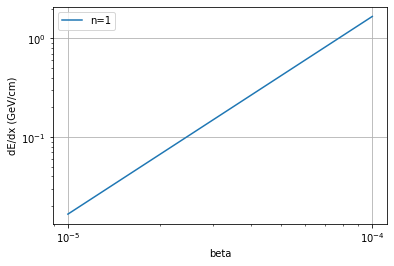

In [1662]:
#for n in [1,2,3,6,9]:
for n in [1]:

    betas = np.logspace(-5, -4, 5)
    Es1 = np.array([impulse_dEdx(beta, theta_min=3e-4, integration_diagnostics=False) for beta in betas])
    #Es2 = np.array([dEdx(beta, 2)[0] for beta in betas])

    plt.plot(betas, Es1[:,0] * 1e-9, label="n=" + str(n))
    #plt.plot(betas, Es2 * 1e-9)

plt.gca().set_xscale("log")
plt.gca().set_yscale("log")

plt.grid()

plt.ylabel("dE/dx (GeV/cm)")
plt.xlabel("beta")
    
plt.legend()


In [1633]:
b, b_min, b_max = impulse_make_b(beta, 1e-12)
beta = 1e-4
T_max = 2 * m_S * beta**2
E_inc = 1/2*m_S*(beta*c)**2 * 6.242e+11
b(theta(T_max, E_inc))

/Users/julianyocum/opt/anaconda3/envs/UROP/lib/python3.7/site-packages/ipykernel_launcher.py:18: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
/Users/julianyocum/opt/anaconda3/envs/UROP/lib/python3.7/site-packages/ipykernel_launcher.py:18: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/Users/julianyocum/opt/anaconda3/envs/UROP/lib/python3.7/site-packages/ipykernel_launcher.py:18: IntegrationWarning: The integral is probably divergent, or slowly convergent.


array(1.06966668e-05)

In [1634]:
T_max

9.3274132e-31

In [1632]:
K_min

5.156343092288361e-14

In [1635]:
.235 / 2 

0.1175